# MNIST Image Completion

In this notebook we train a neural process to complete MNIST images from individual pixel observations, recreating experiment 4.2 from the paper.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as pp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from neural_process import NeuralProcess, log_likelihood

%matplotlib inline

In the following cells we define the three exchangeable parts of a neural process as neural networks. The encoder encodes $(x, y)$ pairs into a kind of summary vector. The z-decoder decodes the aggregated summary vector into the parameters of the latent variable $z$. And finally the decoder decodes an $x$ and a $z$ into the parameters of $p(f(x) | x, z)$.

In [2]:
class MnistEncoder(nn.Module):
    def __init__(self, x_dim, y_dim, r_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(x_dim + y_dim, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, r_dim)
        
    def forward(self, x, y):
        r = torch.cat([x, y], dim=1)
        
        r = F.relu(self.fc1(r))
        r = F.relu(self.fc2(r))
        r = self.fc3(r)
        
        return r

In [3]:
class MnistZDecoder(nn.Module):
    def __init__(self, r_dim, z_dim):
        super().__init__()
        
        self.fc_mu = nn.Linear(r_dim, z_dim)
        self.fc_sigma = nn.Linear(r_dim, z_dim)
    
    def forward(self, r):
        return self.fc_mu(r), F.softplus(self.fc_sigma(r))

In [4]:
class MnistDecoder(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(x_dim + z_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        
        self.fc_mu = nn.Linear(32, y_dim)
        self.fc_sigma = nn.Linear(32, y_dim)
    
    def forward(self, x, z):
        # Concatenate to a tensor of shape [len(x), len(z), x_dim + z_dim]
        x = x.unsqueeze(0).expand(z.shape[0], -1, -1).transpose(0, 1)
        z = z.unsqueeze(0).expand(x.shape[0], -1, -1)
        y = torch.cat([x, z], dim=-1)
        
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))
        
        return self.fc_mu(y), F.softplus(self.fc_sigma(y))

Here we load the train and test sets of MNIST and select a small subset of the test set to compute a running log-likelihood of an unseen dataset as a performance indicator.

In [5]:
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
     torchvision.transforms.Lambda(lambda im: im.reshape(-1, 1))])
mnist_train = torchvision.datasets.MNIST("data", train=True, download=True, transform=transforms)
mnist_test = torchvision.datasets.MNIST("data", train=False, download=True, transform=transforms)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True)

n_pixels = int(np.prod(mnist_train[0][0].size()))

# Select 10 of each digit for validation
indices = [i * 1000 + j for i in range(10) for j in range(10)]
validation_set = torch.utils.data.Subset(mnist_test, indices)

# Create a constant selection of 50 pixels to observe for validation
val_mask = torch.zeros(n_pixels, dtype=torch.uint8)
val_mask[torch.randperm(n_pixels)[:50]] = 1

Now we are ready to instantiate the process model

In [6]:
x_dim = 2
y_dim = 1
r_dim = 32
z_dim = 5
encoder = MnistEncoder(x_dim, y_dim, r_dim)
aggregator = lambda rs: torch.mean(rs, dim=0)
z_decoder = MnistZDecoder(r_dim, z_dim)
decoder = MnistDecoder(x_dim, z_dim, y_dim)
mnist_np = NeuralProcess(encoder, aggregator, z_decoder, decoder)

and define a helper function to show intermediate results every few batches.

In [7]:
def plot_completion(n_proc, img, x):
    npoints = [10, 50, 250]
    
    # Normalize img to [0..1]
    img = (img - img.min())
    img = img / img.max()
    
    fig, axes = pp.subplots(3, len(npoints), squeeze=False)
    
    for i, n in enumerate(npoints):
        mask = torch.zeros(n_pixels, dtype=torch.uint8)
        mask[torch.randperm(n_pixels)[:n]] = 1

        x_ctx = x[mask]
        y_ctx = y[mask]

        mu, sigma = mnist_np(x_ctx, y_ctx, x)
        mask = mask.numpy().astype(np.bool)
        
        # Show observed points
        masked_img = np.tile(img.clone().numpy()[:, :, np.newaxis], (1, 1, 3))
        masked_img[~mask] = [0.0, 0.0, 0.5]
        axes[0][i].imshow(masked_img.reshape(28, 28, 3))
        
        # Show the mean
        mean_img = np.clip(np.tile(mu.detach().numpy(), (1, 1, 3)), 0, 1)
        axes[1][i].imshow(mean_img.reshape(28, 28, 3))
        
        # Show the standard deviation
        std_img = np.clip(np.tile(sigma.detach().numpy(), (1, 1, 3)), 0, 1)
        axes[2][i].imshow(std_img.reshape(28, 28, 3))
        
        axes[0][i].set_title("{} observed points".format(n))
        for j in range(3):
            axes[j][i].axis("off")
        
    pp.show()

Finally, we train the model by maximizing the ELBO over minibatches.

Epoch 1 Batch 1/6000: Loss 0.6957 - Val LLH -445.8404


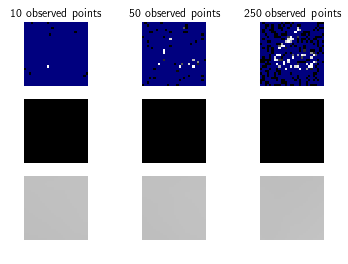

Epoch 1 Batch 3000/6000: Loss -0.8858 - Val LLH 471.0377


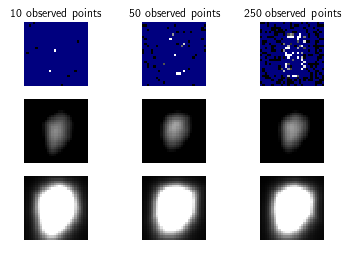

Epoch 1 Batch 6000/6000: Loss -0.8475 - Val LLH 600.0186


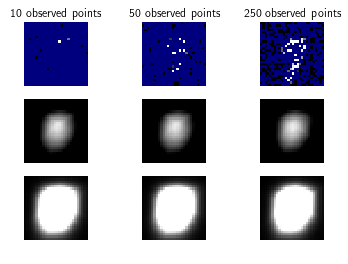

Epoch 2 Batch 3000/6000: Loss -0.9469 - Val LLH 613.0459


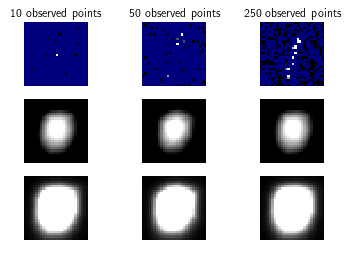

Epoch 2 Batch 6000/6000: Loss -0.7273 - Val LLH 632.5504


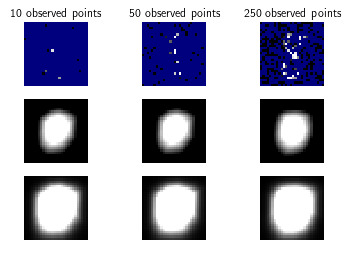

Epoch 3 Batch 3000/6000: Loss -1.1044 - Val LLH 711.5106


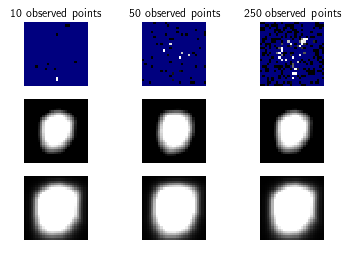

In [ ]:
mnist_np.train()
optimizer = optim.Adam(mnist_np.parameters(), lr=0.0001)

# Construct the image coordinate grid
x = np.stack(np.meshgrid(np.linspace(-1.0, 1.0, 28), np.linspace(-1.0, 1.0, 28)), axis=2).reshape(-1, 2)
x = torch.from_numpy(x).float()

for epoch in range(10):
    for batch, data in enumerate(mnist_train_loader):
        optimizer.zero_grad()
        
        # Iterate over the minibatch
        loss = 0.0
        imgs, _ = data
        for y in imgs:
            # Select observed and target pixels at random
            mask = torch.zeros(n_pixels, dtype=torch.uint8)
            mask[torch.randperm(n_pixels)[:torch.randint(1, n_pixels, (1,), dtype=torch.long)]] = 1
            
            x_ctx = x[mask]
            y_ctx = y[mask]
            x_obs = x[~mask]
            y_obs = y[~mask]
            
            loss += -mnist_np.elbo(x, y, x_ctx, y_ctx, x_obs, y_obs)
        
        # Take the mean over the minibatch
        loss /= imgs.shape[0]
        
        loss.backward()
        optimizer.step()
        
        if (epoch == 0 and batch == 0) or batch in [2999, 5999]:
            val_llh = 0.0
            for y, _ in validation_set:
                x_ctx = x[val_mask]
                y_ctx = y[val_mask]
                x_obs = x[~val_mask]
                y_obs = y[~val_mask]
                mu, sigma = mnist_np(x_ctx, y_ctx, x_obs)
                val_llh += log_likelihood(mu, sigma, y_obs).sum()
            val_llh /= len(validation_set)
            
            print("Epoch {} Batch {}/{}: Loss {:.4f} - Val LLH {:.4f}".format(
                1 + epoch, 1 + batch, len(mnist_train_loader), loss, val_llh))
            plot_index = int(np.random.randint(len(validation_set)))
            plot_completion(mnist_np, validation_set[plot_index][0], x)
            
            torch.save(mnist_np.state_dict(), "checkpoint-{}-{}.pth.tar".format(epoch, batch))

In [ ]:
# My kernel keeps dying so I reload the last checkpoint here
# if os.path.isfile("checkpoint.pth.tar"):
#     mnist_np.load_state_dict(torch.load("checkpoint.pth.tar"))